# Project 5 - Intro to Deep Learning Image Classification

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [LearningSuite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below (at the end of this notebook).

<span style="color:red">PLEASE submit only the notebook -- no additional files.</span>

Please also fill in here the time that each part took you:
1. Part A - Dataset: <span style="color:red;">3 hours</span>
2. Part B - Neural Network Architecture: <span style="color:red;">15 minutes</span>
3. Part C - Network Training: <span style="color:red;">8 hours</span>
4. Part D - Testing: <span style="color:red;">15 minutes</span>
5. Write-up: <span style="color:red;">15 minutes</span>


## Background - Image Classification

For this project you will be introduced to the basics of deep learning and the PyTorch framework.  Deep learning can be very computationally expensive and runs fastest with GPU support.  If you do not have access to NVIDIA GPUs on your local machine, you can use some from Google using their [colab tool](https://colab.research.google.com).  Colab runs exactly like jupyter notebooks and you can directly upload your .ipynb file.

Image classification is the task of taking an image and labeling it as a category.  Deep learning has been the leading method for image classification since it dominated the [ImageNet competition in 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

# Part A: Dataset

You will be performing classification on the [Stanford Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html), which consists of 16,185 images of 196 classes of cars.  The dataset is split 50-50 into a training set and testing set.  You will want to download each one idividually from Stanford's site or use these links: [Train Set](http://imagenet.stanford.edu/internal/car196/cars_train.tgz) and [Test Set](http://imagenet.stanford.edu/internal/car196/cars_test.tgz).  Each set is around 1 GB of data so please **<span style="color:red">DO NOT</span>** include the files when you upload your notebook--**just turn in the .ipynb file**.  Assume the notebooks will be run with the images in folders labeled `cars_train` and `cars_test` like so:

```
.
+--proj5-image-classification.ipynb
+--cars_train
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--cars_test
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--test_annos.json
+--train_annos.json
```

The first step in any deep learning method is to make sure you can read in the data.  Since there will be a lot of images for this project, it is possible not all of them will fit into memory.  This is a common problem in deep learning and PyTorch has provided a pattern so as to only have the images you need in memory at a time.  They provide a class called `DataLoader` that acts as an iterable object.  To use `DataLoader`, you will need to implement a subclass of PyTorch's `Dataset` class.  To do you so will need to create a class that inherits from `Dataset` and implements the methods `__getitem__` and `__len__`.  An example is given below and PyTorch provides a [tutorial here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html):

```Python
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self):
        super(MyDataset, self).__init__()
#         TODO: implement what happens when someone calls: 
#         dataset = MyDataset()
    
    def __getitem__(self, idx):
#         TODO: implement what happens when someone calls dataset[idx]
#         This typically will return an image and its label 
    
    def __len__(self):
#         TODO: implement what happens when someone calls len(dataset)

dataset = MyDataset()
loader = DataLoader(dataset)
for im, label in loader:
#     TODO: Perform operations
```

We provide you with two files: `test_annos.json` and `train_annos.json`.  These files contain a dictionary mapping image name to the class label the image belongs to.  You can use these files in you Dataset class in order to provide the ground truth labels.  For part A, you will need to implement a dataset class.

**Note:** Both the images and the labels are 1-indexed. You can load the images however you choosed, but the labels must be 0-indexed to work with Pytorch's loss functions. Make sure to account for this in your Dataset class.

In [ ]:
# !pip install pillow==4.1.1

In [ ]:
!rm -rf cars_train
!rm -rf cars_test
!rm -rf cars_val

In [ ]:
%%capture
!wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz
!tar -xvzf cars_train.tgz

In [ ]:
%%capture
!wget http://imagenet.stanford.edu/internal/car196/cars_test.tgz
!tar -xvzf cars_test.tgz

In [ ]:
from google.colab import drive
#### USE THIS TO LOAD THE TRAIN AND TEST ANNOTATIONS IN THE NEXT CELL ####
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
from torchvision.models import resnet152
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch
from torch import optim, nn
import zipfile
from google.colab import files
import os
import sys
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt


### NOTE: change these paths to wherever the data is ###
with open("drive/MyDrive/train_annos.json", "r") as fin:
  train_labels = json.load(fin)

with open("drive/MyDrive/test_annos.json", "r") as fin:
  test_labels = json.load(fin)

print(f"Loaded {len(train_labels)} train labels and {len(test_labels)} test labels")

Loaded 8144 train labels and 8041 test labels


In [ ]:
import random
# random.seed(2)
# indexes_of_train = random.sample(list(range(len(train_labels))), k=round(0.8 * len(train_labels)))

In [ ]:
# import glob
# !mkdir cars_val
# for file_idx, file_name in enumerate(tqdm(glob.glob("cars_train/*.jpg"))):
#   if file_idx not in indexes_of_train:
#     !mv $file_name cars_val/

In [ ]:
import os, glob
for folder_name in ["cars_test", "cars_train"]:
  print(f"\nRearranging the folder {folder_name} so that it can be loaded by ImageFolder")
  for jpg_name in tqdm(glob.glob(os.path.join(folder_name, "*.jpg"))):
    label = test_labels[jpg_name.split("/")[-1]] if folder_name == "cars_test" else train_labels[jpg_name.split("/")[-1]]
    label_dir = os.path.join(folder_name, str(label - 1))
    if not os.path.isdir(label_dir):
      !mkdir $label_dir
    !mv $jpg_name $label_dir

  0%|          | 0/8041 [00:00<?, ?it/s]


Rearranging the folder cars_test so that it can be loaded by ImageFolder


  0%|          | 0/8144 [00:00<?, ?it/s]


Rearranging the folder cars_train so that it can be loaded by ImageFolder


100%|██████████| 8144/8144 [15:55<00:00,  8.52it/s]


In [ ]:
resized = False # global resized


In [ ]:

class CarsDataset(Dataset):
    def __init__(self, folder_path: str, data_type="train", resize=False):
        global resized
        super().__init__()
        
        self.train = data_type == "train"
        if not resized:
          for ext in ["_train", "_val", "_test"]:
            self.resize(folder_path + ext, size=400)
          resized=True

        if data_type == "train":
            self.dataset_folder = datasets.ImageFolder(folder_path + "_train", transform=transforms.Compose([transforms.ToTensor(),
                                                                                                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
        elif data_type == "test":
            self.dataset_folder = datasets.ImageFolder(folder_path + '_test', transform=transforms.Compose([transforms.ToTensor(),
                                                                                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
        else:
          print(f"Cannot understand data_type {data_type}")
          return

    def resize(self, path, size=400):
        """Resizes all images in place"""
        print(f"Resizing images in {path}")
        dirs = os.walk(path)
        for root, dirs, files in os.walk(path):
            for item in files:
                name = os.path.join(root, item)
                if "bmp" in name:
                  continue
                if os.path.isfile(name):
                    im = Image.open(name)
                    try:
                      im = ImageOps.fit(im, (size, size))
                    except Exception:
                      print("Removing file {}".format(name))
                      os.remove(name)
                      continue
                    im.save(name[:-3] + 'bmp', 'BMP')
                    os.remove(name)

    def __getitem__(self, i):
        return self.dataset_folder[i]

    def __len__(self):
        return len(self.dataset_folder)

train_data = CarsDataset("cars", data_type="train")
print("Len of train data is {}".format(len(train_data)))

Resizing images in cars_train
Resizing images in cars_val
Resizing images in cars_test
Len of train data is 8144


In [ ]:
train_data[33], train_data[19][0].shape

((tensor([[[-0.6471, -0.7098, -0.8039,  ..., -0.3882, -0.4039, -0.4196],
           [-0.2706, -0.4039, -0.5294,  ..., -0.4510, -0.4588, -0.4588],
           [ 0.2157,  0.0196, -0.1373,  ..., -0.5137, -0.5059, -0.5059],
           ...,
           [-0.0902, -0.2392, -0.3333,  ...,  0.0902,  0.0980,  0.1529],
           [-0.0118, -0.1373, -0.2706,  ...,  0.1137,  0.1137,  0.1529],
           [ 0.0431, -0.0196, -0.1843,  ...,  0.1529,  0.1373,  0.1529]],
  
          [[-0.4980, -0.6000, -0.7647,  ..., -0.7255, -0.7490, -0.7804],
           [-0.1216, -0.2941, -0.4902,  ..., -0.7882, -0.8039, -0.8196],
           [ 0.3569,  0.1216, -0.1059,  ..., -0.8510, -0.8510, -0.8667],
           ...,
           [-0.3255, -0.4667, -0.5765,  ..., -0.1608, -0.1294, -0.0824],
           [-0.2471, -0.3725, -0.5137,  ..., -0.1294, -0.1137, -0.0824],
           [-0.2000, -0.2627, -0.4275,  ..., -0.0902, -0.0902, -0.0824]],
  
          [[-0.3961, -0.5529, -0.7569,  ..., -0.8510, -0.8667, -0.8824],
           

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


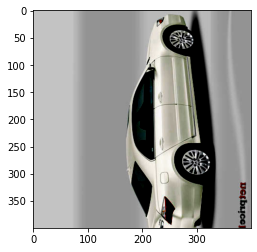

In [ ]:
plt.imshow(train_data[46][0].permute(2, 1, 0))

In [ ]:
!nvidia-smi

Sat Nov 28 01:00:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Part B: Neural Network Architecture

The main backbone for deep learning is the actual neural network architecture.  For image classification, this will consist of some combination of `Conv2d` layers with activations--usually `ReLU`--with intermittent downsampling--usually done using `MaxPool2d`--followed by a few Linear layers.  The input to the network should be an image with shape `(batch_size, channels, image_height, image_width)`(e.g. a single RGB image with dimensions 224x224 would be `(1, 3, 224, 224)`) and the output a vector of shape `(num_classes,)`, where the largest value's index in the output vector indicates the class label.  

While we built our own network in the Learning Lab, for this lab we will used one of Pytorch's pretrained networks. This has the benefit of already having learned features from training on an ImageNet classification problem. To pull in this pretrained network, we use the following line of code:

In [ ]:
import torchvision

model = torchvision.models.resnet34(pretrained=True)

print(list(model.__dict__["_modules"].keys()))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


The ResNet18 is a state of the art network that uses convolution layers, batch normalization, layers of residual blocks, and a fully connected layer at the end. The different layers are listed above. However, because the pretrained network was trained on ImageNet, the last layer is designed to predict 1000 classes, not 196 like in our dataset.

In [ ]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


Our goal is to use the same architecture as the ResNet, but replace the last fully connected layer with a new fully connected layer that goes from 512 input features to 196 output features.

PyTorch provides a nice framework for making a neural network architecture.  A network is typically made as a class that inherits from PyTorch's `Module` class and implements the `forward` method.  A network might take the form of the example below. PyTorch also provides a simple Neural Network [tutorial here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) -- the Training a Classifier tutorial is especially helpful.
```Python
import torch.nn as nn 

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
#         TODO: setup network here

    def forward(self, x):
#         TODO: perform the forward pass, which happens when someone calls network(x)
```

Take all the pretrained layers from ResNet18, but then define your own last fully connected layer. Then write the appropriate forward pass function.

**Note:** ResNet was trained with images that are normalized according to the ImageNet color averages. This means you may want to include an appropriate normalization in your Dataset class if you did not already. This can easily be done with Pytorch's transform objects.

```Python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
```

In [ ]:
class ResNetAll(nn.Module):
    def __init__(self, num_classes, start_frozen=False, model_type="18"):
        super(ResNetAll, self).__init__()

        if model_type == "18":
          self.net = torchvision.models.resnet18(pretrained=True)
          self.net.fc = nn.Linear(self.net.fc.in_features, num_classes) 
        elif model_type == "34":
          self.net = torchvision.models.resnet34(pretrained=True)  
          self.net.fc = nn.Linear(self.net.fc.in_features, num_classes)
        elif model_type == "50":
          self.net = torchvision.models.resnet50(pretrained=True)  
          self.net.fc = nn.Linear(self.net.fc.in_features, num_classes)
        elif model_type == "alex":
          self.net = torchvision.models.alexnet(pretrained=True)
          self.net.classifier[-1] = nn.Linear(self.net.classifier[-1].in_features, num_classes)
        elif model_type == "google":
          self.net = torchvision.models.googlenet(pretrained=True)
          self.net.fc = nn.Linear(self.net.fc.in_features, num_classes)
        elif model_type == "mobile":
          self.net = torchvision.models.mobilenet_v2(pretrained=True)
          self.net.classifier[-1] = nn.Linear(self.net.classifier[-1].in_features, num_classes)


        if start_frozen:
            # Turn off all gradients of the resnet
            for param in self.net.parameters():
              param.requires_grad = False
            for param in self.net.fc.parameters():
              param.requires_grad = True
        
    def unfreeze(self, n_layers):
        # Turn on gradients for the last n_layers
        unfrozen = 0
        for index, child in enumerate(reversed(list(self.net.children()))):
          for param in child.parameters():
            param.requires_grad = True
          if unfrozen == n_layers:
            break
          unfrozen += 1

    def forward(self, x):
        return self.net(x)

# Part C: Training

Now that you can access your data and you have a network architecture set up, its time to put things together and start training.  Training requires two additional major components: 1) the loss function and 2) the optimizer.  The loss function is a comparison between your results and the ground truth data.  The optimizer is what takes the results of the loss function and backpropagates the error to the network weights in an attempt to decrease the loss.  The most common loss function used for classification is [Cross Entropy](https://pytorch.org/docs/stable/nn.html#crossentropyloss) while the most commonly used optimizer is [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).  

A basic training step might take the following form:
```Python
optimizer.zero_grad()
outs = model(inputs)
loss = loss_func(outs, labels)  # loss_func would be an instance of a torch.nn.CrossEntropyLoss class
loss.backward()
optimizer.step()  # optimizer would be an instance of the torch.optim.Adam class
```

For deliverables on this section, please display a plot of the value of the loss over time.  If things are working, the loss should be decreasing.

**Note: This step could take several hours so you will want to look into being able to save your model to a file and load it up again.** See [here](https://pytorch.org/docs/stable/notes/serialization.html).

Also, if you are running on Google Colab, your notebook may eventually get disconnected -- Colab limits the amount of time you can spend using their service at one time. You may want to save intermediate results to your Google Drive: see [here](https://medium.com/@ml_kid/how-to-save-our-model-to-google-drive-and-reuse-it-2c1028058cb2).

In [ ]:
from  sklearn.metrics import confusion_matrix
def accuracy(y_hat, y_truth):
    """Gets average accuracy of a vector of predictions"""
    
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc

def evaluate(model, objective, val_loader, device, ret_conf=False, short=False):
    """Gets average accuracy and loss for the validation set"""

    val_losses = []
    val_accs = []
    preds = []
    trues = []
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()
    with torch.no_grad():
        for index, (x, y_truth) in enumerate(val_loader):
            # print(f"Eval {index}")
            if short and index > 20:
              break
            x, y_truth = x.to(device), y_truth.to(device)
            # print(x.shape, y_truth.shape)
            y_hat = model(x)
            val_loss = objective(y_hat, y_truth)
            val_acc = accuracy(y_hat, y_truth)
            trues.extend(y_truth.flatten().tolist())
            preds.extend(y_hat.flatten().tolist())

            val_losses.append(val_loss.item())
            val_accs.append(val_acc.item())


    model.train()
    acc_preds = torch.tensor(preds).reshape(-1, 196)
    acc_true = torch.tensor(trues).reshape(-1)
    # print(torch.argmax(acc_preds, dim=1)[-10:], trues[-10:])
    # print(acc_preds, acc_preds.shape, acc_true, acc_true.shape)
    # print(torch.argmax(y_hat, dim=1), y_truth.item())
    test_acc = accuracy(acc_preds, acc_true)
    if not ret_conf:
      return torch.mean(torch.Tensor(val_losses)), test_acc
    else:
      
      return torch.mean(torch.Tensor(val_losses)), test_acc, confusion_matrix(trues, torch.argmax(acc_preds, dim=1).tolist())

In [ ]:
import copy
def train(start_frozen=False, car_only: bool = True, model_unfreeze=0, num_classes=196, cpu=False, batch_size=32, epochs = 5,
          lr=0.00005, model_type="18", short=False, dont_eval=False):
    # Start with a very low learning rate
    val_every = 10
    if cpu:
      device = torch.device('cpu:0')
    else:
      device = torch.device('cuda:0')

    # Data
    if car_only:
      train_dataset = CarsDataset("cars", data_type="train")
      test_dataset = CarsDataset("cars", data_type="test")
      # print(train_dataset[0])
    else:
      print("TODO")
      return
     
    train_loader = DataLoader(train_dataset,
                              shuffle=True,
                              num_workers=8,
                              batch_size=batch_size)
    test_loader = DataLoader(test_dataset,
                              shuffle=False,
                              num_workers=8,
                              batch_size=batch_size)
    
    print("Loaded datasets and dataloaders!")
    
    # Model
    model = ResNetAll(num_classes, start_frozen=start_frozen, model_type=model_type).to(device)
    
    # Objective
    objective = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-1)

    # Progress bar
    pbar = tqdm(total=len(train_loader) * epochs)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    cnt = 0
    best_model = None
    best_score = -1
    val_acc = 0
    train_epoch_acc = []
    train_epoch_loss = []
    for epoch in range(epochs):

        if epoch == model_unfreeze and start_frozen:
            model.unfreeze(epoch)
        
        for index, (x, y_truth) in enumerate(train_loader):
            if short and index > 20:
              break
            x, y_truth = x.to(device), y_truth.to(device)

            optimizer.zero_grad()

            y_hat = model(x)
            train_loss = objective(y_hat, y_truth)
            # print(y_hat.shape)
            train_acc = accuracy(y_hat, y_truth)

            train_loss.backward()
            optimizer.step()

            train_accs.append(train_acc.item())
            train_losses.append(train_loss.item())
            pbar.set_description('train loss:{:.4f}, train accuracy:{:.4f}, test accuracy {:.4f}.'.format(train_loss.item(), train_acc, val_acc))
            pbar.update(1)

            
        if not dont_eval:
          val_loss, val_acc = evaluate(model, objective, test_loader, device, short=short)
          if val_acc > best_score:
            print("\nSaving best model here")
            best_model = copy.deepcopy(model.cpu())
            model.to(device)
            best_score = val_acc
          val_losses.append(val_loss)
          val_accs.append(val_acc)
        else:
          best_model = model

        train_epoch_acc.append(np.mean(np.array(train_accs)))
        train_epoch_loss.append(np.mean(np.array(train_losses)))
        train_losses = []
        train_accs = []

            

    pbar.close()
    plt.subplot(121)
    print(train_epoch_acc)
    plt.plot(np.arange(len(train_epoch_acc)), train_epoch_acc, label='Train Accuracy')
    if not dont_eval:
      plt.plot(np.arange(len(train_epoch_acc)), val_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.subplot(122)
    plt.plot(np.arange(len(train_epoch_loss)), train_epoch_loss, label='Train Loss')
    if not dont_eval:
      plt.plot(np.arange(len(train_epoch_loss)), val_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()  
    model.cpu()
    best_model.cpu()
    x.cpu()
    y_truth.cpu()

    return best_model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(tensor([[[ 0.9686,  0.9686,  0.9686,  ...,  0.9686,  0.9686,  0.9686],
          [ 0.8275,  0.8196,  0.8118,  ...,  0.8196,  0.8196,  0.8196],
          [ 0.8588,  0.8510,  0.8353,  ...,  0.8039,  0.8039,  0.8039],
          ...,
          [-0.3412, -0.3255, -0.3333,  ..., -0.0902, -0.1373, -0.1765],
          [-0.3255, -0.3176, -0.3176,  ..., -0.1451, -0.1922, -0.2157],
          [-0.2941, -0.2784, -0.2784,  ..., -0.0745, -0.1059, -0.1059]],
 
         [[ 0.9686,  0.9686,  0.9686,  ...,  0.9765,  0.9765,  0.9765],
          [ 0.8275,  0.8196,  0.8118,  ...,  0.8353,  0.8353,  0.8353],
          [ 0.8588,  0.8510,  0.8353,  ...,  0.8353,  0.8353,  0.8353],
          ...,
          [-0.4588, -0.4510, -0.4588,  ..., -0.2000, -0.2471, -0.2863],
          [-0.4353, -0.4431, -0.4431,  ..., -0.2549, -0.3020, -0.3333],
          [-0.4039, -0.4039, -0.4039,  ..., -0.1843, -0.2235, -0.2235]],
 
         [[ 0.9686,  0.9686,  0.9686,  ...,  0.9765,  0.9765,  0.9765],
          [ 0.8275,  0.8196,

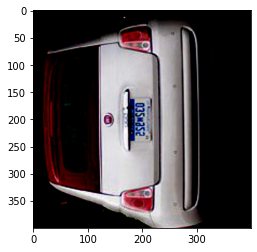

In [ ]:
test_dataset = CarsDataset("cars", data_type="test")
plt.imshow(test_dataset[-1][0].permute(2, 1, 0))
test_dataset[50]

# Effect of number of epochs vs runtime (also shows that the training works)


You can see that as the number of epochs increas, accuracy increases on the training set and then levels off near 100% accuracy.  However, the test set goes up and then levels out much earlier, with the loss starting to even increase near the end of the all the epochs. I assume that is where the overfitting will occur, as the training set loss will be nearly zero and the test set loss will increase.

Loaded datasets and dataloaders!


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


train loss:5.2509, train accuracy:0.0250, test accuracy 0.0000.:   4%|▍         | 64/1472 [02:01<28:28,  1.21s/it]


Saving best model here


train loss:5.0575, train accuracy:0.0250, test accuracy 0.0178.:   9%|▊         | 128/1472 [05:52<28:54,  1.29s/it]


Saving best model here


train loss:4.6878, train accuracy:0.1250, test accuracy 0.0558.:  13%|█▎        | 192/1472 [09:45<27:46,  1.30s/it]


Saving best model here


train loss:4.5362, train accuracy:0.1375, test accuracy 0.0953.:  17%|█▋        | 256/1472 [13:35<26:00,  1.28s/it]


Saving best model here


train loss:4.1590, train accuracy:0.1750, test accuracy 0.1568.:  22%|██▏       | 320/1472 [17:27<24:42,  1.29s/it]


Saving best model here


train loss:3.8849, train accuracy:0.4000, test accuracy 0.2153.:  26%|██▌       | 384/1472 [21:18<23:24,  1.29s/it]


Saving best model here


train loss:3.4309, train accuracy:0.4750, test accuracy 0.2804.:  30%|███       | 448/1472 [25:10<22:00,  1.29s/it]


Saving best model here


train loss:3.1891, train accuracy:0.5000, test accuracy 0.3556.:  35%|███▍      | 512/1472 [29:00<20:45,  1.30s/it]


Saving best model here


train loss:2.9830, train accuracy:0.5500, test accuracy 0.4312.:  39%|███▉      | 576/1472 [32:52<19:16,  1.29s/it]


Saving best model here


train loss:2.6317, train accuracy:0.6750, test accuracy 0.5057.:  43%|████▎     | 640/1472 [36:40<17:48,  1.28s/it]


Saving best model here


train loss:2.3544, train accuracy:0.7500, test accuracy 0.5688.:  48%|████▊     | 704/1472 [40:32<16:22,  1.28s/it]


Saving best model here


train loss:2.1766, train accuracy:0.7875, test accuracy 0.5908.:  52%|█████▏    | 768/1472 [44:23<14:58,  1.28s/it]


Saving best model here


train loss:1.7442, train accuracy:0.8625, test accuracy 0.6199.:  57%|█████▋    | 832/1472 [48:14<13:39,  1.28s/it]


Saving best model here


train loss:1.4941, train accuracy:0.9000, test accuracy 0.6610.:  61%|██████    | 896/1472 [52:06<12:29,  1.30s/it]


Saving best model here


train loss:1.4238, train accuracy:0.9250, test accuracy 0.6936.:  65%|██████▌   | 960/1472 [55:59<10:54,  1.28s/it]


Saving best model here


train loss:1.1042, train accuracy:0.9625, test accuracy 0.6903.:  78%|███████▊  | 1152/1472 [1:07:32<06:52,  1.29s/it]


Saving best model here


train loss:0.6475, train accuracy:0.9875, test accuracy 0.6227.: 100%|██████████| 1472/1472 [1:28:39<00:00,  3.61s/it]


[0.006860351568320766, 0.044824218755820766, 0.0958251953125, 0.16145019535906613, 0.24003906245343387, 0.32033691415563226, 0.42441406240686774, 0.51513671875, 0.6079589845612645, 0.6931640626862645, 0.7586669921875, 0.819067383185029, 0.8673583986237645, 0.9026123052462935, 0.9279052736237645, 0.950292969122529, 0.9641357427462935, 0.9742675786837935, 0.9805175783112645, 0.9829345708712935, 0.9893798828125, 0.99072265625, 0.9937011720612645]


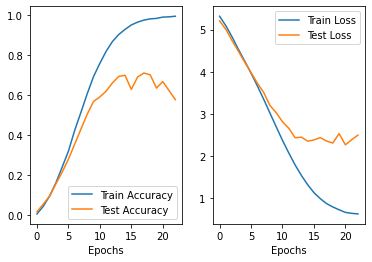

In [ ]:
best_model = train(start_frozen=False, epochs=23, batch_size=128, model_type="18", short=False) 

In [ ]:
!nvidia-smi

Sat Nov 28 02:29:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   79C    P0    47W /  70W |  13833MiB / 15079MiB |     12%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Part D: Testing

One of the goals of deep learning is to make a model that generalizes to data it has never seen (e.g. new images of cars).  For this part, you will test your generalizability by running the model on a dataset it has not yet seen during training.  To do so, you will need to make sure you are not calculating any gradients by using `torch.no_grad` in a with statement. You will also need to put the network into evaluation mode:
```Python
model.eval()
with torch.no_grad():
    # enter testing code here
```

To put the network back into training mode, call `model.train()`.

You will also need to compare your actual predictions with the ground truth, value for value.  The output of your network, however, will be a vector of length 196 (the number of possible classes for the cars dataset) with the largest value representing the guessed class.  You will need to extract the predicted class number and compare it with the ground truth class number for all images in the test dataset and calculate the overall accuracy.  **Print out the overall accuacy of your model**.

Additionally, **you will need to generate a confusion matrix of the 196 categories**. A confusion matrix shows how often a specific category is guessed as each other category. For example, the 11th row and 34th column in the matrix should tell you how many times category 11 images were guessed to be category 34 images. Thus, a perfect predictor on the test set would have nonzero values only along the diagnol. Once you generated the confusion matrix, you may simply plot it as a grayscale image (with interpolation turned off).

While high test accuracy is not the only goal in this lab, most students are able to get above 50% in their testing accuracy. If you are unable to reach this level of accuracy, it may indicate an error in your code.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


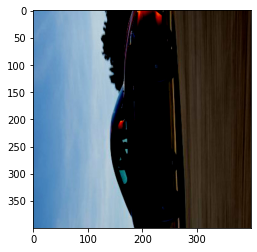

In [ ]:
test_dataset = CarsDataset("cars", data_type="test")
plt.imshow(test_dataset[100][0].permute(2, 1, 0))

The accuracy of the test set is 0.7103593945503235



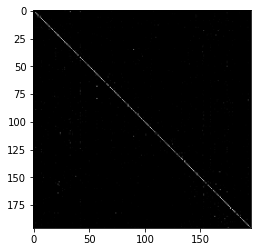

In [ ]:
def test_model(best_model):
    test_dataset = CarsDataset("cars", data_type="test")
    test_loader = DataLoader(test_dataset,
                                  shuffle=False,
                                  num_workers=16,
                                  batch_size=128)
        
    cuda_device = "cuda:0"    
    best_model.to(cuda_device)
    test_loss, test_acc, conf_matrix = evaluate(best_model, nn.CrossEntropyLoss(), test_loader, cuda_device, ret_conf=True)
    print(f"The accuracy of the test set is {test_acc}\n")
    plt.imshow(conf_matrix, cmap="gray")
    return test_acc

test_acc = test_model(best_model)

## Grading
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Making a Dataset class
* [10 pts] Setting up you architecture
* [20 pts] Training your model and plotting training loss
* [30 pts] Displaying the overall accuracy of your model and a confusion matrix

The last 20 points are earned through completing a subset of the following explorations:
* [10 pts] Enhance your dataloader to include reflection data augmentation (i.e. double the size of your training data by taking the mirror image across the y-axis). **DO NOT** do reflection augmentation across the x-axis (we don't care to detect cars when they are upside down!). Describe what effects the augmentation had on testing accuracy.
* [10 pts] Enhance your dataloader to include random resized crop data augmentation (i.e. increase the size of your training data by taking a subsection of your image each time). Make sure the crop is not too small, otherwise you might miss parts of the car. Describe what effects the augmentation had on testing accuracy.
* [10 pts] Analyze the effect of learning rates on the accuracy of the network. Describe what you found and give supporting plots.
* [10 pts] Analyze the effect of changing the number of training epochs on the accuracy of the network. Describe what you found and give supporting plots.
* [10 pts] Analyze the effect of varying the batch_size on the accuracy of the network. Describe what you found and give supporting plots. 
* [10 pts] Analyze the effect of different optimizers on the accuracy of the network. Describe what you found and give supporting plots. A list of optimizers in Pytorch can be found [here](https://pytorch.org/docs/stable/optim.html).
* [10 pts] Analyze the effect of different pretrained networks on the accuracy of the network. Describe what you found and give supporting plots. A list of pretrained networks in Pytorch can be found [here](https://pytorch.org/docs/stable/torchvision/models.html).

You may earn up to 10 points extra credit for additional explorations you complete.

An additional 15 points of extra credit will be given to the individual with the highest test accuracy.

# What I chose
I chose the training epochs vs accuracy (above), the model on accuracy (below) and the learning rate on accuracy (at the end).  I also tried to get the highest accuracy but ran out of time on Google Colab for this month apparently.

In [ ]:
model.cpu()
best_model.cpu()
torch.cuda.empty_cache()
import gc
gc.collect()
!nvidia-smi

Sat Nov 28 02:30:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    47W /  70W |    953MiB / 15079MiB |     90%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Effect of Model on Accuracy

Loaded datasets and dataloaders!


train loss:1.9982, train accuracy:0.6875, test accuracy 0.0000.: 100%|██████████| 5865/5865 [39:40<00:00,  2.46it/s]


[0.01568627450980392, 0.06237745098039216, 0.11801470588235294, 0.17549019607843136, 0.23198529411764707, 0.29497549019607844, 0.3568627450980392, 0.41862745098039217, 0.4670343137254902, 0.5218137254901961, 0.5682598039215686, 0.616421568627451, 0.6381127450980392, 0.665563725490196, 0.6870098039215686, 0.711764705882353, 0.7371323529411765, 0.7493872549019608, 0.7709558823529412, 0.779656862745098, 0.7849264705882353, 0.8068627450980392, 0.8137254901960784]


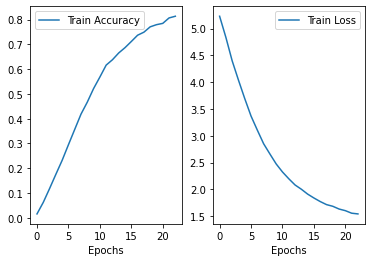

The accuracy of the test set is 0.6271607875823975



ResNetAll(
  (net): MobileNetV2(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

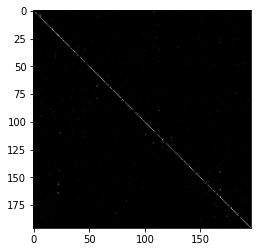

In [ ]:
best_mobile_model = train(start_frozen=False, epochs=23, batch_size=32, model_type="mobile", short=False, dont_eval=True) 
test_acc_mobile = test_model(best_mobile_model)
best_mobile_model.cpu()

Loaded datasets and dataloaders!


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


train loss:4.5274, train accuracy:0.0000, test accuracy 0.0000.: 100%|██████████| 2944/2944 [16:55<00:00,  2.90it/s]


[0.0186767578125, 0.0869140625, 0.1497802734375, 0.168701171875, 0.183837890625, 0.17431640625, 0.175537109375, 0.1741943359375, 0.1688232421875, 0.164306640625, 0.15283203125, 0.146728515625, 0.1412353515625, 0.1383056640625, 0.1339111328125, 0.122314453125, 0.1217041015625, 0.1195068359375, 0.1177978515625, 0.108642578125, 0.113037109375, 0.104736328125, 0.1055908203125]


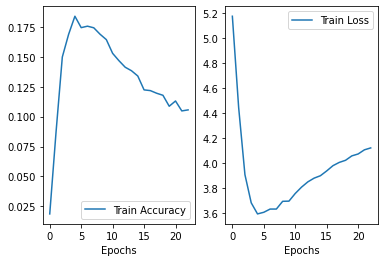

The accuracy of the test set is 0.09488869458436966



ResNetAll(
  (net): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1)

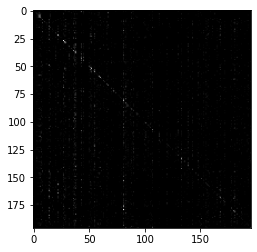

In [ ]:
best_alex_model = train(start_frozen=False, epochs=23, batch_size=64, model_type="alex", short=False, dont_eval=True) 
test_acc_alex = test_model(best_alex_model)
best_alex_model.cpu()

Loaded datasets and dataloaders!


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


train loss:2.9131, train accuracy:0.5625, test accuracy 0.0000.: 100%|██████████| 5865/5865 [43:39<00:00,  2.24it/s]


[0.008823529411764706, 0.021323529411764706, 0.03897058823529412, 0.05551470588235294, 0.08125, 0.1090686274509804, 0.13431372549019607, 0.15894607843137254, 0.18553921568627452, 0.19840686274509803, 0.2172794117647059, 0.23651960784313725, 0.2599264705882353, 0.2824754901960784, 0.30012254901960783, 0.3144607843137255, 0.3209558823529412, 0.33394607843137253, 0.34816176470588234, 0.35404411764705884, 0.36299019607843136, 0.3665441176470588, 0.379656862745098]


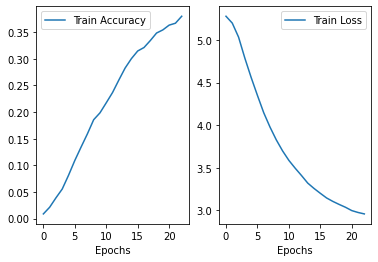

The accuracy of the test set is 0.30481284856796265



ResNetAll(
  (net): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): Bat

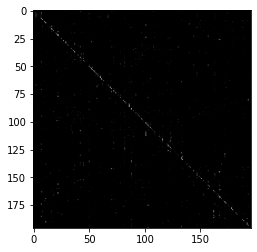

In [ ]:
best_resnet_model = train(start_frozen=False, epochs=23, batch_size=32, model_type="google", short=False, dont_eval=True) 
test_acc_resnet = test_model(best_resnet_model)
best_resnet_model.cpu()

<BarContainer object of 4 artists>

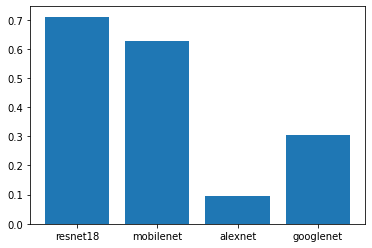

In [ ]:
plt.bar(["resnet18", "mobilenet", "alexnet", "googlenet"], [test_acc, test_acc_mobile, test_acc_alex, test_acc_resnet])

You can see that the models have widely differing accuracy scores, with the resnet18 getting high accuracy (70%) but seems like its starting to overfit, the mobile net getting 63% accuracy but not yet overfitting, the AlexNet struggling to get 15% accuracy, and the GoogleNet getting 30% accuracy.  Thus, it seems like the model you use makes a large difference in the results. (I could tell overfitting because previously I had a graph of test set score over the epochs, however, my collab was re-run and those took too long to regenerate).


# Effect of Learning Rate on Accuracy

Loaded datasets and dataloaders!


train loss:4.2510, train accuracy:0.2375, test accuracy 0.0000.: 100%|██████████| 1472/1472 [41:39<00:00,  1.70s/it]


[0.003662109375, 0.0047607421875, 0.005615234375, 0.009033203125, 0.0135498046875, 0.021020507818320766, 0.030932617199141532, 0.04304199219041038, 0.0562744140625, 0.06694335938664153, 0.08212890627328306, 0.09443359379656613, 0.11601562495343387, 0.13186035165563226, 0.14597167971078306, 0.1661376953125, 0.1873535157646984, 0.20083007821813226, 0.223388671875, 0.24531250004656613, 0.26992187509313226, 0.2921875002793968, 0.30839843745343387]


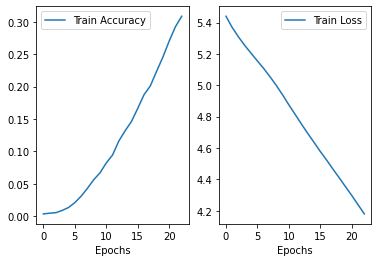

The accuracy of the test set is 0.20582017302513123



ResNetAll(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

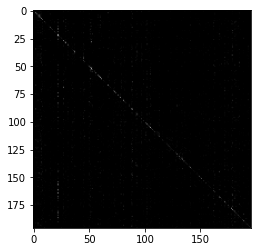

In [ ]:
one = train(start_frozen=False, epochs=23, batch_size=128, model_type="18", short=False, dont_eval=True, lr=0.00001) 
test_acc1 = test_model(one)
one.cpu()

Loaded datasets and dataloaders!


train loss:0.8565, train accuracy:0.9375, test accuracy 0.0000.: 100%|██████████| 1472/1472 [42:17<00:00,  1.72s/it]


[0.0189208984375, 0.1172363281948492, 0.2492431642021984, 0.3975341799668968, 0.5359375001862645, 0.6622558599337935, 0.7464843755587935, 0.8072998048737645, 0.848364258185029, 0.8932128911837935, 0.9062744146212935, 0.9225341798737645, 0.9365722658112645, 0.9502685545012355, 0.955175781622529, 0.9626708989962935, 0.9618652341887355, 0.9671630859375, 0.971411133185029, 0.9713134765625, 0.9718261724337935, 0.978125000372529, 0.9791259765625]


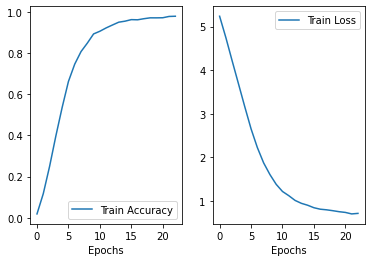

The accuracy of the test set is 0.5919661521911621



ResNetAll(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

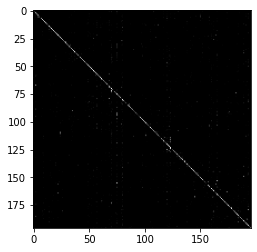

In [ ]:
three = train(start_frozen=False, epochs=23, batch_size=128, model_type="18", short=False, dont_eval=True, lr=0.0001) 
test_acc3 = test_model(three)
three.cpu()

Loaded datasets and dataloaders!


train loss:2.9861, train accuracy:0.2750, test accuracy 0.0000.: 100%|██████████| 1472/1472 [42:19<00:00,  1.73s/it]


[0.08479003910906613, 0.20087890629656613, 0.23835449246689677, 0.255615234375, 0.27739257807843387, 0.28122558584436774, 0.2981933595146984, 0.3101806640625, 0.3180664065293968, 0.3318603518418968, 0.34445800771936774, 0.34555664053186774, 0.35646972665563226, 0.3665771484375, 0.36276855459436774, 0.38344726571813226, 0.37729492178186774, 0.37790527334436774, 0.3974121096543968, 0.3902099612168968, 0.39174804696813226, 0.3966552736237645, 0.40603027353063226]


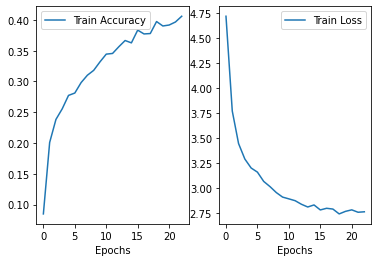

The accuracy of the test set is 0.17385897040367126



ResNetAll(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

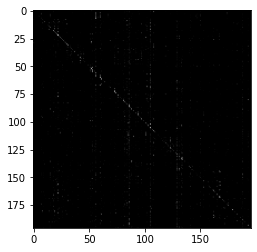

In [ ]:
four = train(start_frozen=False, epochs=23, batch_size=128, model_type="18", short=False, dont_eval=True, lr=0.0005) 
test_acc4 = test_model(four)
four.cpu()

Loaded datasets and dataloaders!


train loss:4.4081, train accuracy:0.0750, test accuracy 0.0000.: 100%|██████████| 1472/1472 [42:16<00:00,  1.72s/it]


[0.063232421875, 0.06352539063664153, 0.060156250023283064, 0.061303710914216936, 0.0634765625, 0.07033691406832077, 0.0736083984375, 0.07004394533578306, 0.08395996096078306, 0.0807373047573492, 0.08085937501164153, 0.08457031252328306, 0.08527832035906613, 0.08745117188664153, 0.078369140625, 0.0833740234375, 0.08754882810171694, 0.08537597657414153, 0.08588867192156613, 0.0836181640625, 0.07758789067156613, 0.07575683598406613, 0.06989746098406613]


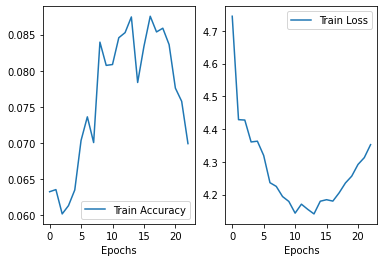

The accuracy of the test set is 0.03681134060025215



ResNetAll(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

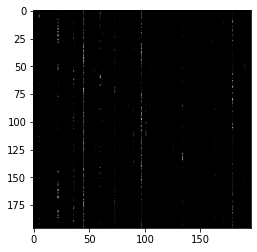

In [ ]:
five = train(start_frozen=False, epochs=23, batch_size=128, model_type="18", short=False, dont_eval=True, lr=0.001)
test_acc5 = test_model(five)
five.cpu()

<BarContainer object of 5 artists>

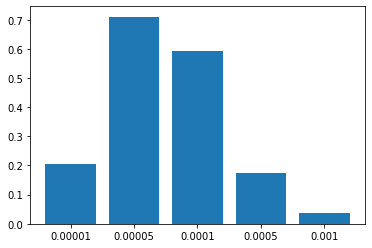

In [ ]:
plt.bar(["0.00001", "0.00005", "0.0001", "0.0005", "0.001"], [test_acc1, test_acc, test_acc3, test_acc4, test_acc5])

We see that the learning rates are in a sort of bell curve (with the learning rates being the exponentially inreasing numbers (0.00001, 0.00005, 0.0001, 0.0005, 0.001).  The smallest one didn't have enough time in the same amount of epochs - the training loss never really curved out.  The 0.001 and 0.0005 were too fast, starting to overfit with the training loss going up.  The 0.0001 and 0.00005 were a good middle ground, getting 60% and 70% accuracy respectively. So it seems like you want a learning rate that is not too much but also not too small, because then it takes too long


# Trying to get the best accuracy (ran out of colab time and didn't do well)

Loaded datasets and dataloaders!


train loss:4.3118, train accuracy:0.2500, test accuracy 0.0000.:   3%|▎         | 255/7650 [02:33<1:01:52,  1.99it/s]


Saving best model here


train loss:3.2161, train accuracy:0.3750, test accuracy 0.2104.:   7%|▋         | 510/7650 [07:06<1:03:17,  1.88it/s]


Saving best model here


train loss:2.5560, train accuracy:0.5625, test accuracy 0.3894.:  10%|█         | 765/7650 [11:40<1:00:53,  1.88it/s]


Saving best model here


train loss:2.5210, train accuracy:0.6875, test accuracy 0.4817.:  13%|█▎        | 1020/7650 [16:14<58:26,  1.89it/s]  


Saving best model here


train loss:1.7835, train accuracy:0.5625, test accuracy 0.5537.:  17%|█▋        | 1275/7650 [20:48<56:35,  1.88it/s]  


Saving best model here


train loss:1.4518, train accuracy:0.6875, test accuracy 0.6076.:  23%|██▎       | 1785/7650 [29:49<51:03,  1.91it/s]  


Saving best model here


train loss:1.1496, train accuracy:0.9375, test accuracy 0.5973.:  30%|███       | 2295/7650 [38:50<46:34,  1.92it/s]


Saving best model here


train loss:1.0728, train accuracy:0.9375, test accuracy 0.6229.:  33%|███▎      | 2550/7650 [43:19<44:16,  1.92it/s]


Saving best model here


train loss:1.2508, train accuracy:0.9375, test accuracy 0.6101.:  40%|████      | 3060/7650 [52:18<40:04,  1.91it/s]


Saving best model here


train loss:1.2987, train accuracy:0.8750, test accuracy 0.6325.:  53%|█████▎    | 4080/7650 [1:10:20<31:29,  1.89it/s]


Saving best model here


train loss:1.3439, train accuracy:0.9375, test accuracy 0.7048.:  77%|███████▋  | 5865/7650 [1:41:54<15:33,  1.91it/s]


Saving best model here


train loss:1.2611, train accuracy:0.9375, test accuracy 0.6754.:  87%|████████▋ | 6630/7650 [1:55:23<08:52,  1.91it/s]


Saving best model here


train loss:1.1264, train accuracy:0.8125, test accuracy 0.6625.: 100%|██████████| 7650/7650 [2:15:17<00:00,  1.06s/it]


[0.07156862745098039, 0.34705882352941175, 0.5693627450980392, 0.6848039215686275, 0.7623774509803921, 0.8068627450980392, 0.8355392156862745, 0.8533088235294117, 0.8681372549019608, 0.8827205882352941, 0.8917892156862746, 0.8931372549019608, 0.9029411764705882, 0.90625, 0.9122549019607843, 0.913235294117647, 0.9229166666666667, 0.9164215686274509, 0.9216911764705882, 0.9208333333333333, 0.9212009803921568, 0.9264705882352942, 0.9303921568627451, 0.9319852941176471, 0.9276960784313726, 0.9299019607843138, 0.935171568627451, 0.9360294117647059, 0.9327205882352941, 0.9273284313725491]


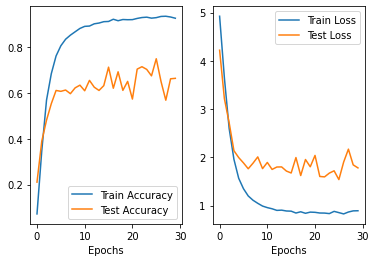

In [ ]:
best_model_mobile = train(start_frozen=False, epochs=30, batch_size=32, model_type="34", short=False) 

Loaded datasets and dataloaders!


train loss:4.7188, train accuracy:0.0625, test accuracy 0.0000.:   3%|▎         | 255/8925 [04:54<2:19:58,  1.03it/s]


Saving best model here


train loss:3.8426, train accuracy:0.0625, test accuracy 0.1234.:   6%|▌         | 510/8925 [11:40<2:15:00,  1.04it/s]


Saving best model here


train loss:3.3809, train accuracy:0.1875, test accuracy 0.1822.:   9%|▊         | 765/8925 [18:26<2:10:59,  1.04it/s]


Saving best model here


train loss:3.3392, train accuracy:0.2500, test accuracy 0.2574.:  11%|█▏        | 1020/8925 [25:11<2:06:57,  1.04it/s]


Saving best model here


train loss:2.5470, train accuracy:0.4375, test accuracy 0.2945.:  17%|█▋        | 1530/8925 [38:41<1:59:15,  1.03it/s]


Saving best model here


train loss:2.6974, train accuracy:0.5000, test accuracy 0.3429.:  20%|██        | 1785/8925 [45:26<1:54:41,  1.04it/s]


Saving best model here


train loss:2.2081, train accuracy:0.7500, test accuracy 0.3934.:  23%|██▎       | 2040/8925 [52:11<1:50:22,  1.04it/s]


Saving best model here


train loss:2.2930, train accuracy:0.5000, test accuracy 0.4246.:  29%|██▊       | 2550/8925 [1:05:41<1:42:27,  1.04it/s]


Saving best model here


train loss:2.5182, train accuracy:0.5000, test accuracy 0.4297.:  40%|████      | 3570/8925 [1:32:28<1:26:06,  1.04it/s]


Saving best model here


train loss:2.3127, train accuracy:0.5000, test accuracy 0.3980.:  46%|████▌     | 4080/8925 [1:45:57<1:17:45,  1.04it/s]


Saving best model here


train loss:2.4389, train accuracy:0.6875, test accuracy 0.3672.:  57%|█████▋    | 5100/8925 [2:12:54<1:01:13,  1.04it/s]


Saving best model here


train loss:2.8452, train accuracy:0.3750, test accuracy 0.3837.: 100%|██████████| 8925/8925 [3:55:10<00:00,  1.58s/it]


[0.040808823529411765, 0.17622549019607844, 0.3145833333333333, 0.38700980392156864, 0.45269607843137255, 0.4863970588235294, 0.5176470588235295, 0.5463235294117647, 0.5681372549019608, 0.5908088235294118, 0.6045343137254902, 0.616421568627451, 0.6333333333333333, 0.6431372549019608, 0.6535539215686275, 0.6587009803921569, 0.6621323529411764, 0.6638480392156862, 0.6747549019607844, 0.6754901960784314, 0.6758578431372549, 0.6600490196078431, 0.6662990196078431, 0.6531862745098039, 0.6522058823529412, 0.640563725490196, 0.6416666666666667, 0.6422794117647059, 0.6213235294117647, 0.6118872549019608, 0.604656862745098, 0.5985294117647059, 0.5852941176470589, 0.573406862745098, 0.5625]


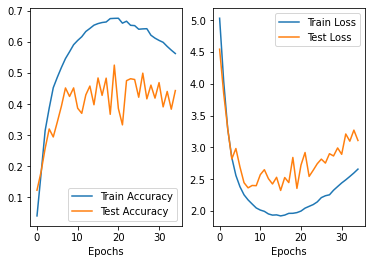

In [ ]:
best_model_50 = train(start_frozen=False, epochs=35, batch_size=32, model_type="50", short=False) 


## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* What insight did you gain from analyzing the confusion matrix?
* What insight did you gain from your explorations?
* What improvements would you recommend for this lab?

Your Write-up Here

- I found getting the training data set up the hardest.  It took some time to 
figure out how to put it in a format to use a Dataset and Dataloader.  It was also hard that the training took a while and I had to periodically come back and check and then re-run and debug, etc.
- From looking at the confusion matrix, you can see that the models that performed well enough (say above 0.3 accuracy) you can see a diagonal line, indicating that it predicted a good amount correctly. For those that did poorly you saw vertical lines which meant it was just predicting a few classes.  You could also see some dots off the diagonal line for the good models, indicating the commonly misclassified classes (perhaps the two looked alike or something).
- From my explorations, I learned that you need your learning rate to be a good balance between fast and slow, that different pre-trained models have a big impact on performance, and that over time, a model tends to underfit, come into a good range, and then overfit (as the number of epochs continue). So there is a good medium ground for the number of epochs also.
- One of the hardest parts of this lab was getting everything set up on Colab and then the timing portion. Using a smaller dataset would be nice, because then everything would be faster.  I know this isn't a huge dataset, so it's probably about the smallest you can do without using MNIST, but I thought I'd mention it.
